In [1]:
# Import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt


### Data Loading and Preparation:
Load the processed dataset (processed_data.csv), which has all preprocessed features.

In [2]:
# Load preprocessed data
data = pd.read_csv("../data/processed/processed_data.csv")

In [3]:
# Convert 'created_at' and 'actual_delivery_time' to datetime format, handling errors
data['created_at'] = pd.to_datetime(data['created_at'], errors='coerce', utc=True)
data['actual_delivery_time'] = pd.to_datetime(data['actual_delivery_time'], errors='coerce', utc=True)

In [4]:
# Ensure only numeric columns are used as features
X = data.select_dtypes(include=[np.number]).drop(columns=['total_delivery_duration'])
y = data['total_delivery_duration']

# Handle infinite values, if any, in the feature set
X.replace([np.inf, -np.inf], np.nan, inplace=True)

### Handling Missing Values:
We specifically handle missing values in min_item_price and estimated_store_to_consumer_driving_duration, using the median, to ensure no NaN values are present.

In [5]:
# Handle missing values (if any remain after preprocessing)
X['min_item_price'].fillna(X['min_item_price'].median(), inplace=True)
X['estimated_store_to_consumer_driving_duration'].fillna(
    X['estimated_store_to_consumer_driving_duration'].median(), inplace=True
)

/var/folders/j1/pdsb5w0x52sgplylm6f7fmgm0000gn/T/ipykernel_51220/3172428726.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['min_item_price'].fillna(X['min_item_price'].median(), inplace=True)
/var/folders/j1/pdsb5w0x52sgplylm6f7fmgm0000gn/T/ipykernel_51220/3172428726.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

### Feature Scaling:
We use StandardScaler to scale features to a standard normal distribution. Scaling is essential for neural networks as it helps improve convergence.

In [6]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [7]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Neural Network Architecture:
- Layer 1: Dense layer with 128 neurons and ReLU activation, followed by batch normalization and dropout for regularization.
- Layer 2: Dense layer with 64 neurons, batch normalization, and dropout.
- Layer 3: Dense layer with 32 neurons.
- Output Layer: Single neuron (linear activation) for regression to predict total_delivery_duration.

Batch Normalization is added after the dense layers to stabilize training and help the model converge faster.

Dropout Layers are used to prevent overfitting by randomly dropping a fraction of neurons during each training step.

In [8]:
# Define the neural network model
model = Sequential([
    Dense(128, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/Users/diegovelez/Documents/Documents - Ifrit/03 RESOURCES/Courses/Henry/Delivery Duration Prediction - DoorDash/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Early Stopping:
We use EarlyStopping with patience=10 to prevent overfitting by stopping the training when the validation loss stops improving.

In [9]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stop])

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Deep Learning MAE: {mae}')

Epoch 1/100
4936/4936 ━━━━━━━━━━━━━━━━━━━━ 5s 736us/step - loss: 3468355.0000 - mean_absolute_error: 1451.7192 - val_loss: 682255.7500 - val_mean_absolute_error: 640.7743
Epoch 2/100
4936/4936 ━━━━━━━━━━━━━━━━━━━━ 4s 789us/step - loss: 784281.0625 - mean_absolute_error: 689.9312 - val_loss: 668545.2500 - val_mean_absolute_error: 633.6065
Epoch 3/100
4936/4936 ━━━━━━━━━━━━━━━━━━━━ 4s 725us/step - loss: 781802.6250 - mean_absolute_error: 687.4222 - val_loss: 663004.8750 - val_mean_absolute_error: 633.5276
Epoch 4/100
4936/4936 ━━━━━━━━━━━━━━━━━━━━ 4s 764us/step - loss: 762611.7500 - mean_absolute_error: 679.5967 - val_loss: 658995.4375 - val_mean_absolute_error: 630.7128
Epoch 5/100
4936/4936 ━━━━━━━━━━━━━━━━━━━━ 4s 753us/step - loss: 760347.3125 - mean_absolute_error: 678.6139 - val_loss: 660012.7500 - val_mean_absolute_error: 628.9672
Epoch 6/100
4936/4936 ━━━━━━━━━━━━━━━━━━━━ 4s 735us/step - loss: 750262.6250 - mean_absolute_error: 675.4520 - val_loss: 658678.3125 - val_mean_absolute_

### Plotting Training and Validation Loss:
- After training, we plot the training and validation loss to visualize model convergence and check for overfitting or underfitting.

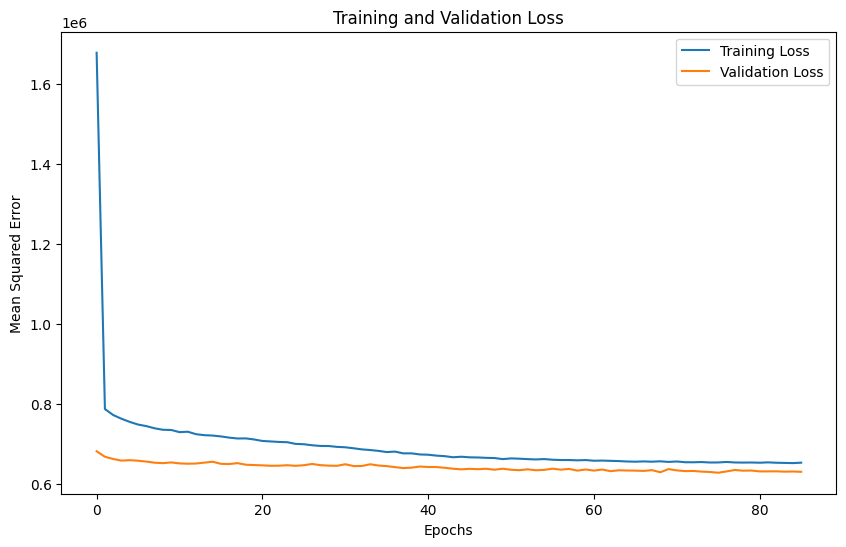

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Comments:

1. Steep Initial Drop in Training Loss:
- In the early epochs, there’s a sharp decline in the training loss, indicating that the model is quickly learning patterns from the data. This is typical in neural network training and shows that the model is converging well initially.
	
2. Validation Loss Stability:
- The validation loss stabilizes fairly quickly and remains relatively flat throughout the training process. This suggests that the model is not overfitting and is maintaining generalizability on unseen data.

- The validation loss is consistently lower than the training loss, which is unusual but can happen. This might be due to regularization techniques (like dropout) or certain patterns in the validation set that are easier for the model to predict.

3. Training Loss Plateau:
- After about 40 epochs, the training loss reaches a plateau with minimal improvement. This implies that the model has captured most of the learnable patterns in the training data, and further epochs are contributing little additional learning.

Overall, this graph suggests that the model is performing well and is not overfitting. The training process is stable, and the loss values indicate a good level of generalization.


### Improved Deep Learning Model

In [13]:
# Load preprocessed data
data = pd.read_csv("../data/processed/processed_data.csv")

In [15]:
# Check if 'busy_dashers_per_order' and 'workload_ratio' exist, if not, create them
if 'busy_dashers_per_order' not in data.columns:
    data['busy_dashers_per_order'] = data['total_busy_dashers'] / (data['total_outstanding_orders'] + 1)
if 'workload_ratio' not in data.columns:
    data['workload_ratio'] = data['total_outstanding_orders'] / (data['total_onshift_dashers'] + 1)

In [16]:
# Select the most important features based on XGBoost analysis
selected_features = [
    'total_delivery_duration_is_outlier', 'subtotal_is_outlier', 'workload_metric',
    'estimated_order_place_duration', 'hour_of_day', 'order_protocol_6.0',
    'num_distinct_items_is_outlier', 'estimated_store_to_consumer_driving_duration',
    'market_id_freq', 'store_primary_category_pizza', 'order_protocol_4.0',
    'store_primary_category_salad', 'store_primary_category_dessert',
    'busy_dashers_per_order', 'workload_ratio', 'store_primary_category_fast',
    'order_protocol_5.0', 'store_primary_category_bubble-tea', 'total_items_is_outlier',
    'store_primary_category_brazilian'
]

X = data[selected_features]
y = data['total_delivery_duration']

In [18]:
# Specific handling for columns with inf/-inf values
# Replace inf and -inf with NaN
data[['min_item_price', 'busy_dashers_per_order', 'workload_ratio']] = data[['min_item_price', 'busy_dashers_per_order', 'workload_ratio']].replace([np.inf, -np.inf], np.nan)

# Fill NaN values with the median for each feature
for feature in ['min_item_price', 'busy_dashers_per_order', 'workload_ratio']:
    data[feature] = data[feature].fillna(data[feature].median())

In [19]:
# Filter dataset for selected features
X = data[selected_features]
y = data['total_delivery_duration']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [20]:
# Define the improved neural network model
model = Sequential([
    Dense(256, input_dim=X_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model with mean squared error loss and Adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

/Users/diegovelez/Documents/Documents - Ifrit/03 RESOURCES/Courses/Henry/Delivery Duration Prediction - DoorDash/env/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [21]:
# Early stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [22]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f'Deep Learning MAE: {mae}')

Epoch 1/100
4936/4936 ━━━━━━━━━━━━━━━━━━━━ 8s 1ms/step - loss: 7973973.5000 - mean_absolute_error: 2655.4543 - val_loss: 3123881.0000 - val_mean_absolute_error: 1572.5809
Epoch 2/100
4936/4936 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 2101090.7500 - mean_absolute_error: 1183.0040 - val_loss: 664620.0625 - val_mean_absolute_error: 627.0051
Epoch 3/100
4936/4936 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 753232.5625 - mean_absolute_error: 675.8323 - val_loss: 655767.5625 - val_mean_absolute_error: 627.7563
Epoch 4/100
4936/4936 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 748270.0625 - mean_absolute_error: 674.0614 - val_loss: 652809.4375 - val_mean_absolute_error: 624.3908
Epoch 5/100
4936/4936 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 754488.0625 - mean_absolute_error: 676.3213 - val_loss: 653815.1875 - val_mean_absolute_error: 628.6423
Epoch 6/100
4936/4936 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 747521.0625 - mean_absolute_error: 672.7632 - val_loss: 647793.5000 - val_mean_absolute_error: 6

Explanation of Changes

1. Increased Network Depth: We used a deeper architecture with more layers to allow the model to capture complex patterns in the data.

2. Higher Dropout Rates: Higher dropout rates in the initial layers help prevent overfitting.

3. Batch Normalization: Batch normalization was added after each dense layer to stabilize training and potentially reduce the number of epochs needed.

4. Early Stopping: Early stopping was used to prevent overfitting.

Model Performance

Mean Absolute Error (MAE): The model achieved an MAE of 610.14 seconds (approximately 10.17 minutes). While this is close to the optimized XGBoost model’s MAE of 525.25 seconds, it still lags slightly behind.


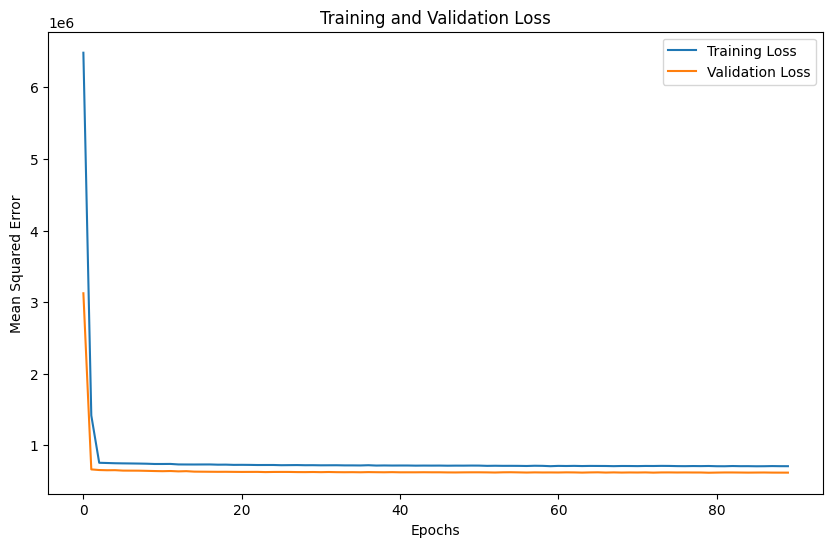

In [23]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Graph Analysis

1. Loss Convergence: The training and validation loss curves show a rapid decrease within the first 10 epochs, after which they stabilize. This indicates that the model learned the key patterns in the data relatively quickly and reached a plateau in terms of improvement.
 
2. Close Alignment of Curves: The training and validation loss curves are closely aligned, suggesting minimal overfitting. This is a positive sign, as it shows that the model generalizes well to unseen data.

3. Low Variability: The stability of the loss over epochs implies that the model is learning effectively and consistently without large fluctuations. This can be attributed to the architecture improvements, including batch normalization and dropout, which helped prevent overfitting.

### Conclusions and Recommendations

1. Comparative Performance: The optimized XGBoost model still outperforms the deep learning model slightly. This suggests that the problem might be better suited to gradient-boosted decision trees, as they can capture complex interactions in structured tabular data more effectively.

2. Further Tuning: Although the deep learning model is stable, there might be further improvements by experimenting with even deeper architectures or fine-tuning dropout rates and layer sizes. However, these adjustments may provide diminishing returns.

3. Ensemble Strategy: Combining predictions from the deep learning model and XGBoost through an ensemble approach could potentially leverage the strengths of both models and slightly improve performance.

Final Recommendation

While the deep learning model is robust and demonstrates reasonable performance, the optimized XGBoost model is the preferable choice due to its lower MAE. Therefore, unless additional improvements are identified, using the XGBoost model as the final solution may be more effective for this project.